In [110]:
import torch
from torchvision import models, transforms, datasets, utils
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io, transform

import numpy as np

import os

import time

# set pytorch model directories
os.environ['TORCH_HOME'] = 'models'

In [111]:
device = 'cpu'

In [112]:
train_labels = pd.read_csv('./train.csv')
train_labels.head()

,ImageID,bboxes
0,0,"[85, 174, 87, 161]"
1,1,"[72, 165, 72, 169]"
2,2,"[36, 215, 63, 189]"
3,3,"[52, 202, 69, 207]"
4,4,"[83, 146, 53, 157]"


In [113]:
def format_bbox(curr_bbox):
    return [int("".join([j for j in i if j.isdigit()])) for i in curr_bbox.split(',')]

img_index = 11
img_id = train_labels.iloc()[img_index]['ImageID']
bbox = format_bbox(train_labels.iloc()[img_index]['bboxes'])

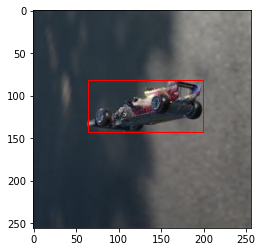

In [114]:
def show_bbox(image, true_bbox):
    plt.imshow(image)
    currentAxis = plt.gca()
    currentAxis.add_patch(patches.Rectangle((true_bbox[0], true_bbox[2]), abs(true_bbox[0] - true_bbox[1]), abs(true_bbox[2] - true_bbox[3]), fill=None, alpha=1, color='red'))
    plt.pause(0.001) 

plt.figure()
show_bbox(io.imread(os.path.join('./train/', str(img_id) + '.jpg')), bbox)
plt.show()

In [115]:
class F1BboxDataset(Dataset):
    """F1 Bbox dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with bboxes.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.bbox_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bbox_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                str(self.bbox_frame.iloc[idx]['ImageID'])+'.jpg')
        image = io.imread(img_name)
        bbox = format_bbox(self.bbox_frame.iloc[idx]['bboxes'])
        bbox = np.array(bbox)
        sample = {'image': image, 'true_bbox': bbox}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (256, 256, 3) [ 85 174  87 161]


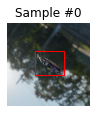

1 (256, 256, 3) [ 72 165  72 169]


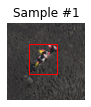

2 (256, 256, 3) [ 36 215  63 189]


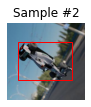

3 (256, 256, 3) [ 52 202  69 207]


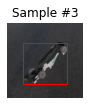

In [116]:
f1_dataset = F1BboxDataset(csv_file='./train.csv',
                                    root_dir='./train')

fig = plt.figure()

for i in range(len(f1_dataset)):
    sample = f1_dataset[i]

    print(i, sample['image'].shape, sample['true_bbox'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

In [334]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bboxes = sample['image'], sample['true_bbox']

        # swap color axis because
        # numpy image: H x W x C 
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).to(device).float() / 1,
                'true_bbox': torch.from_numpy(bboxes).to(device).float()}
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, true_bbox = sample['image'], sample['true_bbox']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        true_bbox = np.array([true_bbox[0] * (new_w/w), true_bbox[1] * (new_w/w), true_bbox[2] * (new_h/h), true_bbox[3] * (new_h/h)])

        return {'image': img, 'true_bbox': true_bbox}

In [356]:
transformed_f1_dataset = F1BboxDataset(csv_file='./train.csv',
                                    root_dir='./train',
                                      transform=transforms.Compose([Rescale((256,256)), ToTensor()]))

In [357]:
# Helper function to show a batch
def show_bbox_batched(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, bbox_batch = \
            sample_batched['image'], sample_batched['true_bbox']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

In [358]:
dataloader = DataLoader(transformed_f1_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


0 torch.Size([1, 3, 256, 256]) torch.Size([1, 4])
tensor([[[[0.3137, 0.3137, 0.3137,  ..., 0.2157, 0.2157, 0.2157],
          [0.3137, 0.3137, 0.3137,  ..., 0.2157, 0.2157, 0.2157],
          [0.3137, 0.3137, 0.3137,  ..., 0.2157, 0.2157, 0.2157],
          ...,
          [0.4667, 0.4667, 0.4667,  ..., 0.3725, 0.3725, 0.3725],
          [0.4667, 0.4667, 0.4667,  ..., 0.3725, 0.3725, 0.3725],
          [0.4667, 0.4667, 0.4667,  ..., 0.3725, 0.3725, 0.3725]],

         [[0.4941, 0.4941, 0.4941,  ..., 0.3882, 0.3882, 0.3882],
          [0.4941, 0.4941, 0.4941,  ..., 0.3882, 0.3882, 0.3882],
          [0.4941, 0.4941, 0.4941,  ..., 0.3882, 0.3882, 0.3882],
          ...,
          [0.6118, 0.6118, 0.6118,  ..., 0.5176, 0.5176, 0.5176],
          [0.6118, 0.6118, 0.6118,  ..., 0.5176, 0.5176, 0.5176],
          [0.6118, 0.6118, 0.6118,  ..., 0.5176, 0.5176, 0.5176]],

         [[0.6235, 0.6235, 0.6235,  ..., 0.5255, 0.5255, 0.5255],
          [0.6235, 0.6235, 0.6235,  ..., 0.5255, 0.5255, 0

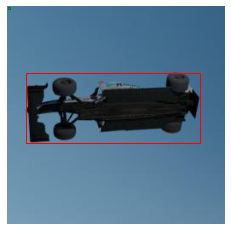

In [359]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['true_bbox'].size())

    # observe 4th batch and stop.
    if i_batch == 3 or True:
        plt.figure()
        #show_bbox_batched(sample_batched)
        print(sample_batched['image'])
        plt.imshow(transforms.ToPILImage()(sample_batched['image'][0].cpu()))
        currentAxis = plt.gca()
        true_bbox = sample_batched['true_bbox'][0]
        
        classification, predicted_bbox = model(sample_batched['image'])
        predicted_bbox = predicted_bbox[0].detach().numpy()
        currentAxis.add_patch(patches.Rectangle((predicted_bbox[0], predicted_bbox[2]), abs(predicted_bbox[0] - predicted_bbox[1]), abs(predicted_bbox[2] - predicted_bbox[3]), fill=None, alpha=1, color='green'))
        
        currentAxis.add_patch(patches.Rectangle((true_bbox[0], true_bbox[2]), abs(true_bbox[0] - true_bbox[1]), abs(true_bbox[2] - true_bbox[3]), fill=None, alpha=1, color='red'))
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Should have everything we need now!

In [340]:
class SplitNet(nn.Module):
    def __init__(self):
        super(SplitNet, self).__init__()
        
        self.body = models.resnet18(pretrained=True)
        
        self.final_layer_n = (list(self.body.modules())[-1].out_features)
        
        self.bbox_layer = nn.Sequential(
            nn.Linear(self.final_layer_n, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        
        self.detection_layer = nn.Sequential(
            nn.Linear(self.final_layer_n, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out = self.body(x)
        return self.detection_layer(out), self.bbox_layer(out)
    

    def freeze_body_params(self):
        for param in self.body.parameters():
            param.requires_grad = False
        
    def unfreeze_body_params(self):
        for param in self.body.parameters():
            param.requires_grad = True

In [341]:
# define resnet-18
model = SplitNet()
model = model.to(device)

model.freeze_body_params()
    
# Define Optimizer and Loss Function
loss_func = nn.MSELoss()
optimiser = torch.optim.Adamax(model.parameters())

In [342]:
transformations = transforms.Compose([
    Rescale((256, 256)),
    ToTensor()
])

train_dataset = F1BboxDataset(csv_file='./train.csv',
                                    root_dir='./train',
                                      transform=transformations)
valid_dataset = F1BboxDataset(csv_file='./val.csv',
                                    root_dir='./val',
                                      transform=transformations)

train_data_size = len(train_dataset)
valid_data_size = len(valid_dataset)
print(train_data_size)
print(valid_data_size)

20000
2000


In [343]:
training_batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=training_batch_size, shuffle=True)
print(train_data_size/training_batch_size)
print(valid_data_size/training_batch_size)

625.0
62.5


In [353]:
epochs = 2
history = []
best_loss = 100000.0
best_epoch = None
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, batch in enumerate(train_data_loader):
        epoch_start = time.time()

        inputs = batch['image']
        bboxes = batch['true_bbox'] 

        # Clean existing gradients
        optimiser.zero_grad()

        # Forward pass - compute outputs on input data using the model
        detection_outputs, bbox_outputs = model(inputs)

        # Compute loss
        loss = loss_func(bbox_outputs, bboxes)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimiser.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)


        print("Batch number: {:03d}, Training: Loss: {:.4f}".format(i, loss.item()))


    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, batch in enumerate(valid_data_loader):
            inputs = batch['image']
            bboxes = batch['true_bbox'] 

            # Forward pass - compute outputs on input data using the model
            detection_outputs, bbox_outputs = model(inputs)

            # Compute loss
            loss = loss_func(bbox_outputs, bboxes)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}".format(j, loss.item()))
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 
    avg_train_acc = train_acc/train_data_size


    history.append([avg_train_loss, avg_valid_loss])

    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss - {:.4f}, \n\t\tValidation : Loss - {:.4f}, Time: {:.4f}s".format(epoch, avg_train_loss, avg_valid_loss,  epoch_end-epoch_start))

Epoch: 1/2
Batch number: 000, Training: Loss: 20175.9746
Batch number: 001, Training: Loss: 18912.7500
Batch number: 002, Training: Loss: 19121.6816
Batch number: 003, Training: Loss: 19439.3828
Batch number: 004, Training: Loss: 19137.7930
Batch number: 005, Training: Loss: 17574.8008


KeyboardInterrupt: 